# Segmentation map 으로 도로 이미지 만들기
pix2pix 논문에서 아래의 이미지처럼 도로의 세그멘테이션 레이블 정보를 활용해 이미지를 생성한 결과
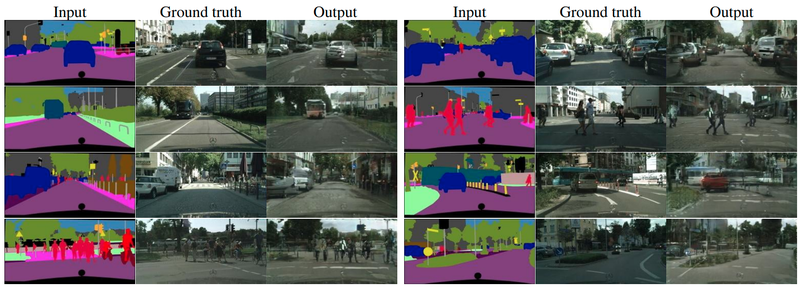
위와 같은 데이터셋을 이용해 pix2pix를 학습시키는것이 목표  
사용한 데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지를 포함

### 데이터 가져오기

In [10]:
import numpy
import tensorflow
import os
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model


print(numpy.__version__)
print(tensorflow.__version__)

1.21.4
2.6.0


In [2]:
train_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/segmentation/cityscapes/train/'
print('number of train examples : ', len(os.listdir(train_data_path)))

number of train examples :  1000


In [3]:
val_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/segmentation/cityscapes/val/'
print('number of test examples : ', len(os.listdir(val_data_path)))

number of test examples :  5


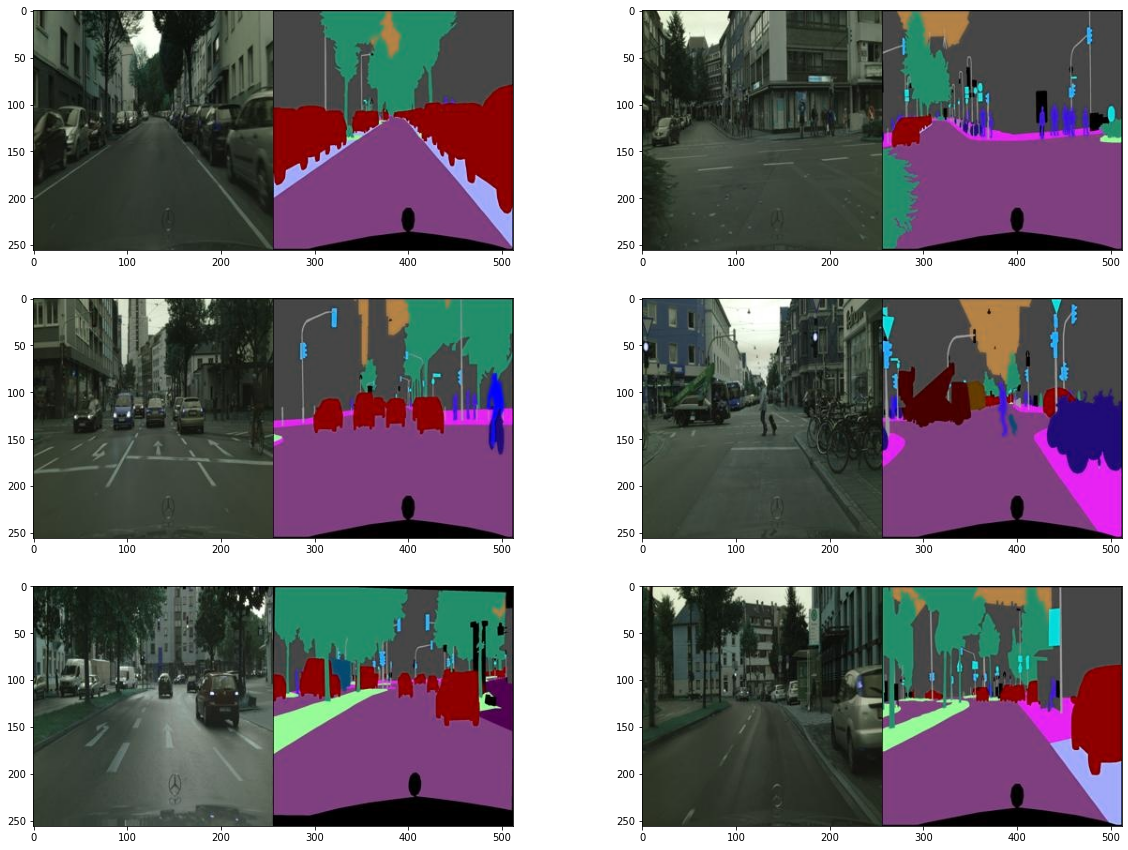

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

학습에 쓸 이미지가 붙어있으므로 분할해준다

In [5]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 256, 3)크기의 이미지 두개로 나눌 수 있겠다

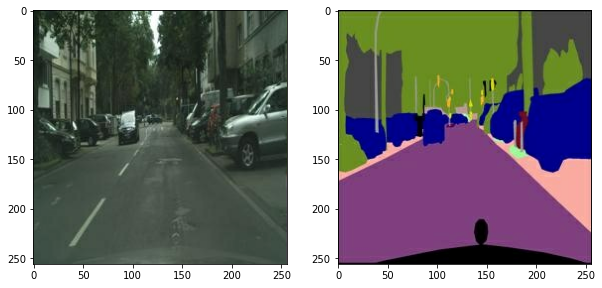

In [6]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real = img[:, :w, :] 
    real = tf.cast(real, tf.float32)
    segmen = img[:, w:, :] 
    segmen = tf.cast(segmen, tf.float32)
    return normalize(real), normalize(segmen)

f = train_data_path + os.listdir(train_data_path)[1]
real,segmen = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(segmen))

### Data augmentation (데이터 증강)
학습 데이터가 부족하여 다양성을 확보하지 못한 경우 augmentation 방법 적용  
이미지를 임의로 자르거나 돌리거나 뒤집어 단조로운 학습을 피할 수 있고, 학습 데이터 양도 늘어남  
그 외에도 RGB 색변환, 밝기 조절, 블러 처리 등이 더 있지만 제출 시간이 촉박하므로 노드에서 진행했던 과정만 진행

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(real, segmen):
    images = tf.concat([real, segmen], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(images, _pad, "REFLECT")
    else:
        padded = tf.pad(images, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)

    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

이미지 크롭, 회전, 뒤집기 등을 데이터에 적용

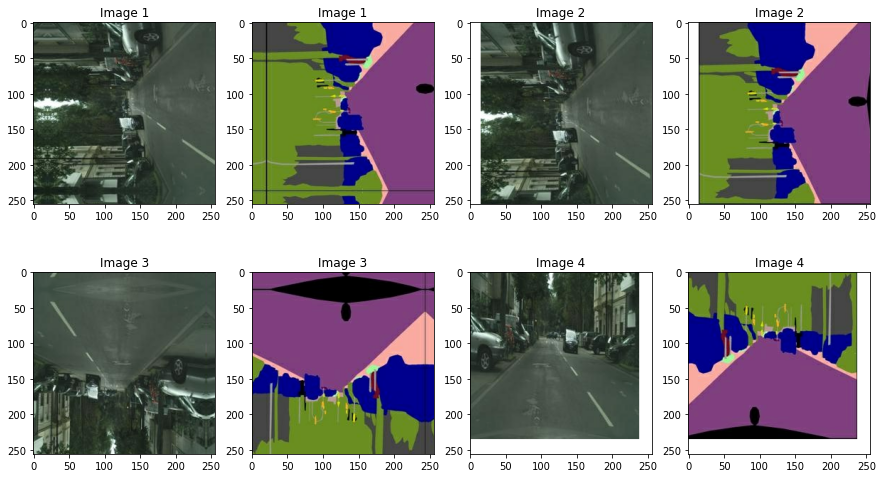

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 9, 2):
    augmented_real, augmented_segmen = apply_augmentation(real, segmen)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_segmen)); plt.title(f"Image {img_n}")
    img_n += 1

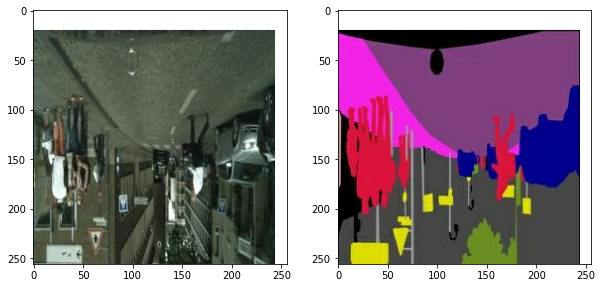

In [9]:
def get_train(img_path):
    real, segmen = load_img(img_path)
    real, segmen = apply_augmentation(real, segmen)
    return real, segmen

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
real, segmen = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(real[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(segmen[0].astype(np.uint8))

## Generator 만들기
### Encoder 구현
Convolution - BatchNorm - LeakyReLU 3개 레이어로 구성된 기본 블럭

In [16]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, 'same', use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

__init__() 메시더에서 n_filters, use_bn 인자를 설정하여 필터 갯수와 배치정규화 사용 여부 결정 가능  
필터 크기 4 스트라이드 2

In [19]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

각 블록을 거치면서 사용할 필터 수를 filters 리스트에 할당  
EncodeBlock으로 만들어진 블록을 block 리스트에 넣어주고  
call() 메서드를 통해 순서대로 블록을 통과  
첫번째 Encoder 블록에서는 bn을 사용하지않음

In [20]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

### Decoder 구현
Encoder와 같은 구조로 블럭을 만들고 블럭을 반복하여 구성

In [21]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

처음 세개의 필터에 대해서만 dropout을 적용하였음  
dropout = 서로 연결된 신경망에서 일정 확률로 뉴런을 제거하는 기법
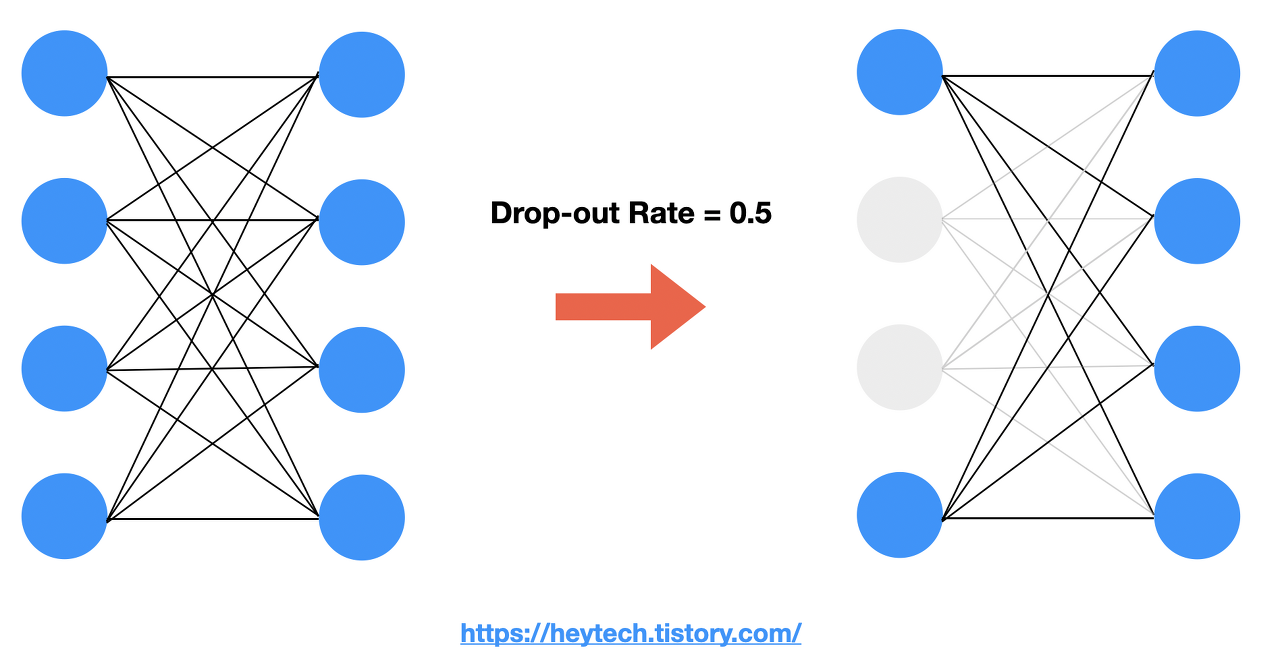

In [22]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

Encoder와 Decoder 연결하기

In [23]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_4 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________
